In [ ]:
!pip install torchmetrics
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torchmetrics.functional import dice_score
from torchmetrics import JaccardIndex
import albumentations as A

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!nvidia-smi -L
#!unzip "/content/drive/MyDrive/HW3_Part1_Dataset/lgg-mri-segmentation.zip" -d "/content/drive/MyDrive/HW3_Part1_Dataset"

Part B

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, _type, transform=None):
        self.transform = transform
        self.imgs_path = "/content/drive/MyDrive/HW3_Part1_Dataset/kaggle_3m"
        self.img_dim = (256, 256)
        self.images_path = []
        self.masks_path = []
        
        np.random.seed(seed=42)
        x = np.arange(110)
        np.random.shuffle(x)
        train, test, val = x[0:88], x[88:99], x[99:110]


        for ptient_idx, folders in enumerate(os.listdir(self.imgs_path)):
          if _type == 'Train' and ptient_idx in train:
            for idx, filename in enumerate(os.listdir(os.path.join(self.imgs_path,folders))):
              _path = os.path.join(self.imgs_path, folders, filename)
              if _path[-8:-4] != "mask":
                self.images_path.append(_path)
                self.masks_path.append(_path[:-4] + '_mask.tif')

          if _type == 'Test' and ptient_idx in test:
            for idx, filename in enumerate(os.listdir(os.path.join(self.imgs_path,folders))):
              _path = os.path.join(self.imgs_path, folders, filename)
              if _path[-8:-4] != "mask":
                self.images_path.append(_path)
                self.masks_path.append(_path[:-4] + '_mask.tif')
          
          if _type == 'Val' and ptient_idx in val:
            for idx, filename in enumerate(os.listdir(os.path.join(self.imgs_path,folders))):
              _path = os.path.join(self.imgs_path, folders, filename)
              if _path[-8:-4] != "mask":
                self.images_path.append(_path)
                self.masks_path.append(_path[:-4] + '_mask.tif')  
           
    
  def __len__(self):
        return len(self.images_path)
    
    
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        img = cv2.imread(self.images_path[idx])
        mask = cv2.imread(self.masks_path[idx], cv2.IMREAD_GRAYSCALE)
      
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
            transform = transforms.ToTensor()
            img = transform(transformed_image)
            mask = transform(transformed_mask)
        else:
            transform = transforms.ToTensor()
            img = transform(img)
            mask = transform(mask)

        return (img - 0.5) / 0.5, mask
        

In [ ]:
trainloader = torch.utils.data.DataLoader(CustomDataset('Train'), batch_size=32,   
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(CustomDataset('Test'), batch_size=32,
                                         shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(CustomDataset('Val'), batch_size=32,
                                         shuffle=True, num_workers=2)


In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, 
                       init_features=32, pretrained=False)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [ ]:
def Train_Model(model, optimizer, criterion, trainloader, testloader, valloader):
  jaccard = JaccardIndex(num_classes=2)
  loss_train = []
  dice_train = []
  jaccard_train = []

  loss_val = []
  dice_val = []
  jaccard_val = []
  for epoch in range(10):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, masks = data[0].to(device), data[1].to(device)
        
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, masks)
          loss.backward()
          optimizer.step()
          
          ########################## Print Statistics ##########################
          loss_train.append(loss.item())
          print('[%d, %5d] loss Train: %.20f' % (epoch + 1, i + 1, loss_train[-1]))
          
          dice = 0
          for _batch in range(len(masks[:, 0, 0, 0])):
            dice += dice_score(outputs[_batch, 0], masks[_batch, 0].to(torch.int))
          dice_train.append((dice / len(masks[:, 0, 0, 0])).item())
          print("dice: ", dice_train[-1])

          jaccard_train.append(jaccard(outputs.cpu(), masks.to(torch.int).cpu()).item())
          print("jaccard: ", jaccard_train[-1])
          
      ################################## Val #################################
      with torch.no_grad():
        each_loss_val = 0
        each_dice_val = 0
        each_jaccard_val = 0
        for j, data_val in enumerate(valloader, 0):
          inputs_val, masks_val = data_val[0].to(device), data_val[1].to(device)
          
          outputs_val = model(inputs_val)
          loss = criterion(outputs_val, masks_val)
          each_loss_val += loss.item()
          
          dice = 0
          for _batch in range(len(masks_val[:, 0, 0, 0])):
            dice += dice_score(outputs_val[_batch, 0], masks_val[_batch, 0].to(torch.int))
          each_dice_val += (dice / len(masks_val[:, 0, 0, 0])).item()
          each_jaccard_val += jaccard(outputs_val.cpu(), masks_val.to(torch.int).cpu()).item()
        
        loss_val.append(each_loss_val / len(valloader))
        dice_val.append(each_dice_val / len(valloader))
        jaccard_val.append(each_jaccard_val / len(valloader))

  ################################## Test #################################
  loss_test = 0
  dice_test = 0
  jaccard_test = 0
  with torch.no_grad():
        for j, data_test in enumerate(testloader, 0):
          inputs_test, masks_test = data_test[0].to(device), data_test[1].to(device)
          outputs_test = model(inputs_test)
          loss = criterion(outputs_test, masks_test)
          loss_test += loss.item()
          
          dice = 0
          for _batch in range(len(masks_test[:, 0, 0, 0])):
            dice += dice_score(outputs_test[_batch, 0], masks_test[_batch, 0].to(torch.int))
          dice_test += (dice / len(masks_test[:, 0, 0, 0])).item()
        
          jaccard_test += jaccard(outputs_test.cpu(), masks_test.to(torch.int).cpu()).item()
              
  return loss_train, dice_train, jaccard_train, loss_val, dice_val, jaccard_val, loss_test/len(testloader), dice_test/len(testloader), jaccard_test/len(testloader)
  

In [ ]:
loss_train, dice_train, jaccard_train, loss_val, dice_val, jaccard_val, loss_test, dice_test, jaccard_test = Train_Model(model, optimizer, criterion, trainloader, testloader, valloader)

[1,     1] loss Train: 0.63311833143234252930
dice:  0.002915180055424571
jaccard:  0.2984246611595154
[1,     2] loss Train: 0.58176982402801513672
dice:  0.020982548594474792
jaccard:  0.4843001067638397
[1,     3] loss Train: 0.54347956180572509766
dice:  0.03643167018890381
jaccard:  0.5038543343544006
[1,     4] loss Train: 0.52539378404617309570
dice:  0.03269604220986366
jaccard:  0.5149710774421692
[1,     5] loss Train: 0.49978280067443847656
dice:  0.06770776957273483
jaccard:  0.562318742275238
[1,     6] loss Train: 0.48532062768936157227
dice:  0.06431147456169128
jaccard:  0.5413072109222412
[1,     7] loss Train: 0.47184598445892333984
dice:  0.09390773624181747
jaccard:  0.5756527781486511
[1,     8] loss Train: 0.45590329170227050781
dice:  0.07994367927312851
jaccard:  0.5605407953262329
[1,     9] loss Train: 0.44659122824668884277
dice:  0.08084547519683838
jaccard:  0.5850411653518677
[1,    10] loss Train: 0.43185552954673767090
dice:  0.08129609376192093
jaccard:

Text(0.5, 1.0, 'Val jaccard (For 10 Epoch)')

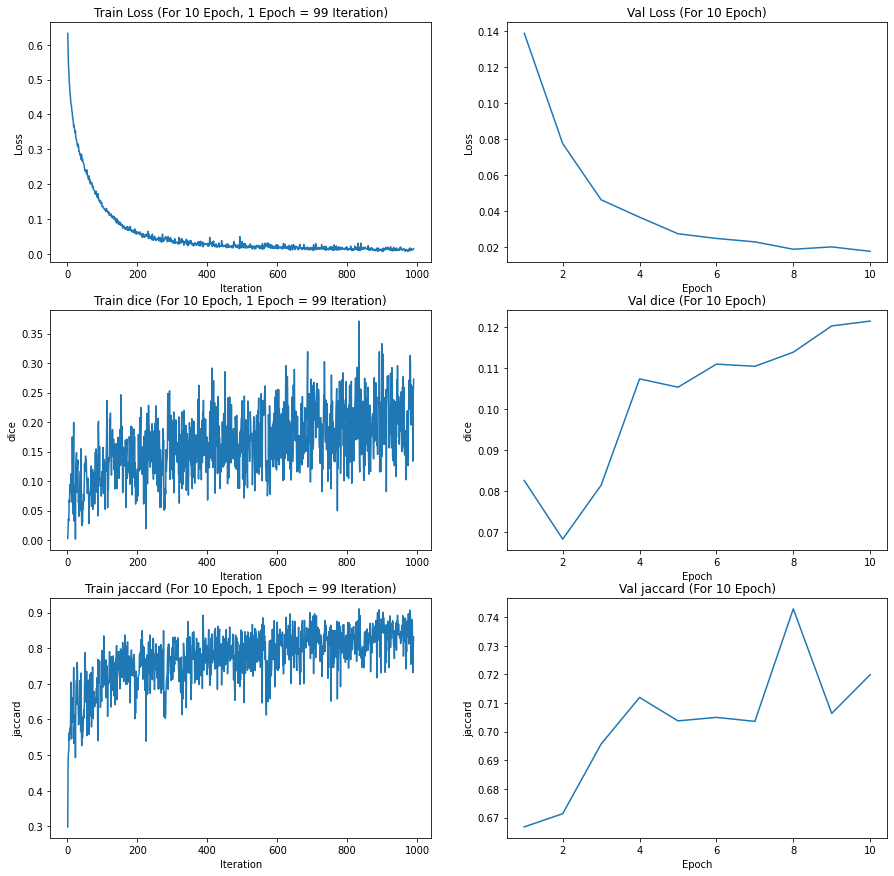

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(15, 15))
axarr[0, 0].plot(range(1, 991), loss_train)
axarr[0, 0].set_xlabel('Iteration')
axarr[0, 0].set_ylabel('Loss')
axarr[0, 0].set_title("Train Loss (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[0, 1].plot(range(1, 11), loss_val)
axarr[0, 1].set_xlabel('Epoch')
axarr[0, 1].set_ylabel('Loss')
axarr[0, 1].set_title("Val Loss (For 10 Epoch)")

axarr[1, 0].plot(range(1, 991), dice_train)
axarr[1, 0].set_xlabel('Iteration')
axarr[1, 0].set_ylabel('dice')
axarr[1, 0].set_title("Train dice (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[1, 1].plot(range(1, 11), dice_val)
axarr[1, 1].set_xlabel('Epoch')
axarr[1, 1].set_ylabel('dice')
axarr[1, 1].set_title("Val dice (For 10 Epoch)")

axarr[2, 0].plot(range(1, 991), jaccard_train)
axarr[2, 0].set_xlabel('Iteration')
axarr[2, 0].set_ylabel('jaccard')
axarr[2, 0].set_title("Train jaccard (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[2, 1].plot(range(1, 11), jaccard_val)
axarr[2, 1].set_xlabel('Epoch')
axarr[2, 1].set_ylabel('jaccard')
axarr[2, 1].set_title("Val jaccard (For 10 Epoch)")

In [ ]:
print('loss_test:', loss_test)
print('dice_test:', dice_test)
print('jaccard_test:', jaccard_test)

loss_test: 0.03128378232872
dice_test: 0.13781028121281
jaccard_test: 0.701218721872


Part C - Augmentation

Choosen Augmentations:

1- Horizontal Flip

2- Crop and zoom

3- Rotation

In [ ]:
Augmentation = A.Compose([
          A.HorizontalFlip(p=0.2),
          A.RandomSizedCrop(min_max_height=(200, 200), height=256, width=256, p=0.2),
          A.Rotate(10, p=0.2),
        ])

In [ ]:
trainloader = torch.utils.data.DataLoader(CustomDataset('Train', Augmentation), batch_size=32,   
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(CustomDataset('Test', Augmentation), batch_size=32,
                                         shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(CustomDataset('Val', Augmentation), batch_size=32,
                                         shuffle=True, num_workers=2)


In [ ]:
model_augment = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, 
                       init_features=32, pretrained=False)
model_augment = model_augment.to(device)
optimizer_augment = optim.Adam(model_augment.parameters(), lr=0.001)
criterion = nn.BCELoss()

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
loss_train, dice_train, jaccard_train, loss_val, dice_val, jaccard_val, loss_test, dice_test, jaccard_test = Train_Model(model_augment, optimizer_augment, criterion, trainloader, testloader, valloader)

[1,     1] loss Train: 0.69586759805679321289
dice:  0.017023609951138496
jaccard:  0.30303362011909485
[1,     2] loss Train: 0.65183556079864501953
dice:  0.02386477030813694
jaccard:  0.36128634214401245
[1,     3] loss Train: 0.61747741699218750000
dice:  0.01685922220349312
jaccard:  0.42200854420661926
[1,     4] loss Train: 0.59299707412719726562
dice:  0.046376265585422516
jaccard:  0.43870115280151367
[1,     5] loss Train: 0.56747937202453613281
dice:  0.03549514338374138
jaccard:  0.4416401982307434
[1,     6] loss Train: 0.54516118764877319336
dice:  0.030296403914690018
jaccard:  0.44548499584198
[1,     7] loss Train: 0.53901648521423339844
dice:  0.0204501710832119
jaccard:  0.4449704885482788
[1,     8] loss Train: 0.51082730293273925781
dice:  0.06984217464923859
jaccard:  0.5176990032196045
[1,     9] loss Train: 0.50745558738708496094
dice:  0.05366348475217819
jaccard:  0.47208619117736816
[1,    10] loss Train: 0.48770639300346374512
dice:  0.05816766619682312
jacc

Text(0.5, 1.0, 'Val jaccard (For 10 Epoch)')

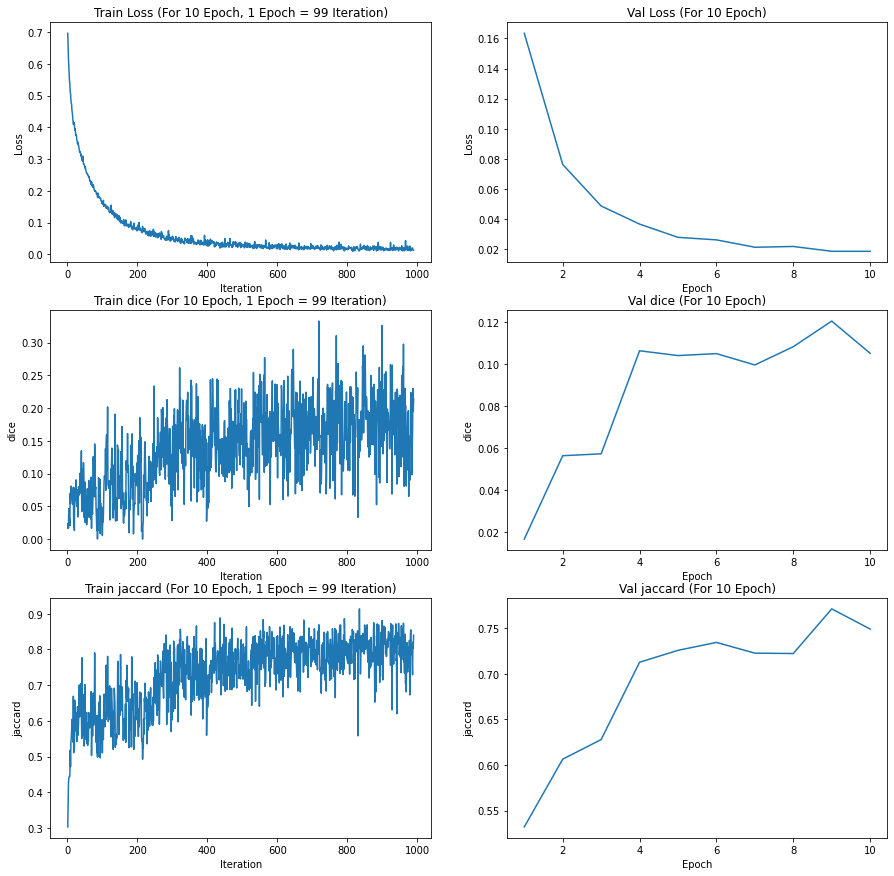

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(15, 15))
axarr[0, 0].plot(range(1, 991), loss_train)
axarr[0, 0].set_xlabel('Iteration')
axarr[0, 0].set_ylabel('Loss')
axarr[0, 0].set_title("Train Loss (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[0, 1].plot(range(1, 11), loss_val)
axarr[0, 1].set_xlabel('Epoch')
axarr[0, 1].set_ylabel('Loss')
axarr[0, 1].set_title("Val Loss (For 10 Epoch)")

axarr[1, 0].plot(range(1, 991), dice_train)
axarr[1, 0].set_xlabel('Iteration')
axarr[1, 0].set_ylabel('dice')
axarr[1, 0].set_title("Train dice (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[1, 1].plot(range(1, 11), dice_val)
axarr[1, 1].set_xlabel('Epoch')
axarr[1, 1].set_ylabel('dice')
axarr[1, 1].set_title("Val dice (For 10 Epoch)")

axarr[2, 0].plot(range(1, 991), jaccard_train)
axarr[2, 0].set_xlabel('Iteration')
axarr[2, 0].set_ylabel('jaccard')
axarr[2, 0].set_title("Train jaccard (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[2, 1].plot(range(1, 11), jaccard_val)
axarr[2, 1].set_xlabel('Epoch')
axarr[2, 1].set_ylabel('jaccard')
axarr[2, 1].set_title("Val jaccard (For 10 Epoch)")

In [ ]:
print('loss_test:', loss_test)
print('dice_test:', dice_test)
print('jaccard_test:', jaccard_test)

loss_test: 0.02551405403452615
dice_test: 0.14860813164462647
jaccard_test: 0.7465280443429947


Part D - Residual

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.conv1_1_enc_1 = nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.conv1_1_enc_2 = nn.Conv2d(in_channels=features, out_channels=features * 2, kernel_size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.conv1_1_enc_3 = nn.Conv2d(in_channels=features * 2, out_channels=features * 4, kernel_size=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.conv1_1_enc_4 = nn.Conv2d(in_channels=features * 4, out_channels=features * 8, kernel_size=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #######################################################################################################
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")
        self.conv1_1_bn = nn.Conv2d(in_channels=features * 8, out_channels=features * 16, kernel_size=1)
        #######################################################################################################
        
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.conv1_1_dec_4 = nn.Conv2d(in_channels=(features * 8) * 2, out_channels=features * 8, kernel_size=1)
        
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.conv1_1_dec_3 = nn.Conv2d(in_channels=(features * 4) * 2, out_channels=features * 4, kernel_size=1)
        
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.conv1_1_dec_2 = nn.Conv2d(in_channels=(features * 2) * 2, out_channels=features * 2, kernel_size=1)
        
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        self.conv1_1_dec_1 = nn.Conv2d(in_channels=features * 2, out_channels=features, kernel_size=1)
        
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = F.relu(self.encoder1(x) + self.conv1_1_enc_1(x))
        x = self.pool1(enc1)
        enc2 = F.relu(self.encoder2(x) + self.conv1_1_enc_2(x))
        x = self.pool2(enc2)
        enc3 = F.relu(self.encoder3(x) + self.conv1_1_enc_3(x))
        x = self.pool3(enc3)
        enc4 = F.relu(self.encoder4(x) + self.conv1_1_enc_4(x))
        x = self.pool4(enc4)
        ###################################################################
        bottleneck = F.relu(self.bottleneck(x) + self.conv1_1_bn(x))
        ###################################################################
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = F.relu(self.decoder4(dec4) + self.conv1_1_dec_4(dec4))

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = F.relu(self.decoder3(dec3) + self.conv1_1_dec_3(dec3))
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = F.relu(self.decoder2(dec2) + self.conv1_1_dec_2(dec2))
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = F.relu(self.decoder1(dec1) + self.conv1_1_dec_1(dec1))
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    #(name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
model_residual = UNet()
model_residual = model_residual.to(device)
optimizer_residual = optim.Adam(model_residual.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
loss_train, dice_train, jaccard_train, loss_val, dice_val, jaccard_val, loss_test, dice_test, jaccard_test = Train_Model(model_residual, optimizer_residual, criterion, trainloader, testloader, valloader)

[1,     1] loss Train: 0.64033913612365722656
dice:  0.004930232651531696
jaccard:  0.34804752469062805
[1,     2] loss Train: 0.56229275465011596680
dice:  0.0030939998105168343
jaccard:  0.4438166916370392
[1,     3] loss Train: 0.49792447686195373535
dice:  0.023673873394727707
jaccard:  0.508222222328186
[1,     4] loss Train: 0.45383396744728088379
dice:  0.02137315273284912
jaccard:  0.5166584849357605
[1,     5] loss Train: 0.41479271650314331055
dice:  0.03055156208574772
jaccard:  0.5628322958946228
[1,     6] loss Train: 0.38498538732528686523
dice:  0.0011666750069707632
jaccard:  0.4917188584804535
[1,     7] loss Train: 0.35488668084144592285
dice:  0.027387339621782303
jaccard:  0.5316831469535828
[1,     8] loss Train: 0.32703167200088500977
dice:  0.01911853440105915
jaccard:  0.5095658898353577
[1,     9] loss Train: 0.29452073574066162109
dice:  0.031662821769714355
jaccard:  0.5709845423698425
[1,    10] loss Train: 0.26647821068763732910
dice:  0.024141304194927216


Text(0.5, 1.0, 'Val jaccard (For 10 Epoch)')

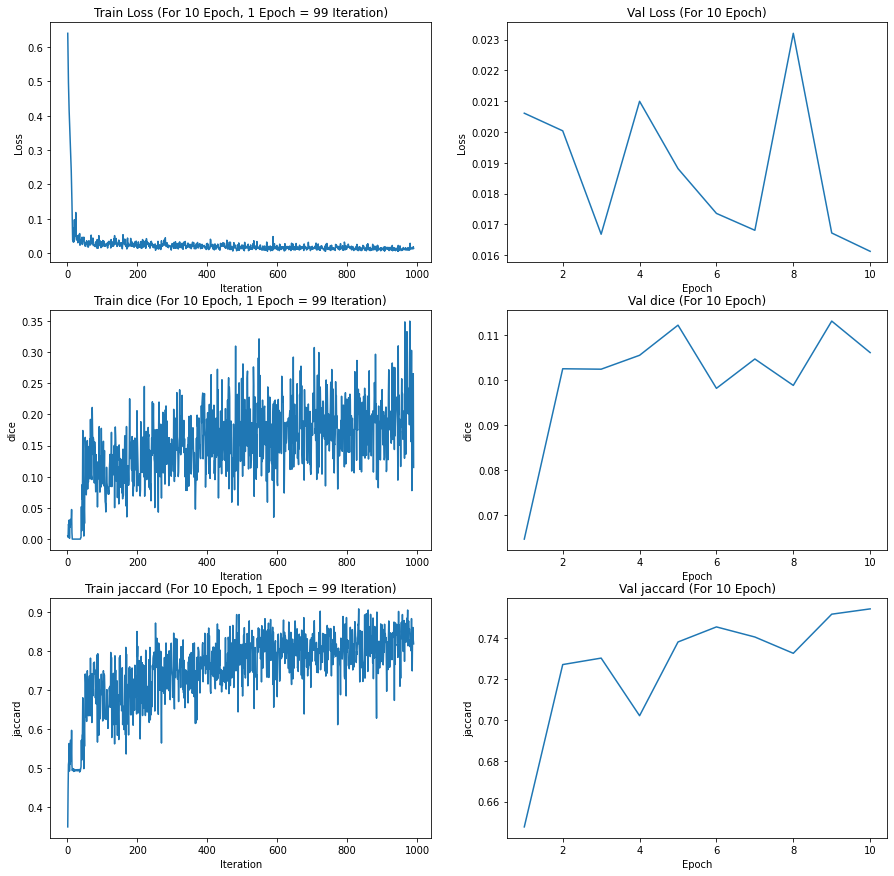

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(15, 15))
axarr[0, 0].plot(range(1, 991), loss_train)
axarr[0, 0].set_xlabel('Iteration')
axarr[0, 0].set_ylabel('Loss')
axarr[0, 0].set_title("Train Loss (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[0, 1].plot(range(1, 11), loss_val)
axarr[0, 1].set_xlabel('Epoch')
axarr[0, 1].set_ylabel('Loss')
axarr[0, 1].set_title("Val Loss (For 10 Epoch)")

axarr[1, 0].plot(range(1, 991), dice_train)
axarr[1, 0].set_xlabel('Iteration')
axarr[1, 0].set_ylabel('dice')
axarr[1, 0].set_title("Train dice (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[1, 1].plot(range(1, 11), dice_val)
axarr[1, 1].set_xlabel('Epoch')
axarr[1, 1].set_ylabel('dice')
axarr[1, 1].set_title("Val dice (For 10 Epoch)")

axarr[2, 0].plot(range(1, 991), jaccard_train)
axarr[2, 0].set_xlabel('Iteration')
axarr[2, 0].set_ylabel('jaccard')
axarr[2, 0].set_title("Train jaccard (For 10 Epoch, 1 Epoch = 99 Iteration)")

axarr[2, 1].plot(range(1, 11), jaccard_val)
axarr[2, 1].set_xlabel('Epoch')
axarr[2, 1].set_ylabel('jaccard')
axarr[2, 1].set_title("Val jaccard (For 10 Epoch)")

In [ ]:
print('loss_test:', loss_test)
print('dice_test:', dice_test)
print('jaccard_test:', jaccard_test)

loss_test: 0.02344940253533423
dice_test: 0.1473506564895312
jaccard_test: 0.7398859163125356
